<a href="https://colab.research.google.com/github/skmisht/CNN/blob/Anton_Keras/CNN_Keras_DiffApproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Melanoma detection using - Keras. Different approach


#Mount Google Drive

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Load csv data

In [ ]:
import pandas as pd

#upload truth data
training_truth_data = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Part3_GroundTruth.csv') 
testing_truth_data = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv') 
validation_truth_data = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Validation_Part3_GroundTruth.csv')

#upload metadata
training_metadata = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv')
testing_metadata = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_metadata.csv')
validation_metadata = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data_metadata.csv')

# path to images
path_training_images ='/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/'
path_testing_images ='/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data/'
path_validation_images = '/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data/'


#Hyper Parameters and constants

In [ ]:
#constants
size = 128
image_resize = (size, size)
input_shape = (size, size, 3)

#model parameters
batch_size = 32
epochs = 100
num_classes = 2

#optimiser parameters
learning_rate = 1e-5


#Import Data

```
1.   Training Data
2.   Validation Data
3.   Training Data

```



In [ ]:
import pandas as pd 
#add new column to truth_data witht he path to corresponding image
def prepare_data(truth_data, metadata, image_path):
  path_to_images_array = []
  for x in truth_data.values:
    path_to_image = image_path+str(x[0])+'.jpg'
    path_to_images_array.append(str(path_to_image))
  #add path to image to the truth data frame
  truth_data['path_to_image'] = path_to_images_array
  #return merge truth data with metadata, join on the image_id's
  return pd.merge(truth_data, metadata, left_on='image_id', right_on='image_id', how='left')

#load data to dataframes
training_data = prepare_data(training_truth_data, training_metadata, path_training_images)
testing_data = prepare_data(testing_truth_data, testing_metadata, path_testing_images)
validation_data = prepare_data(validation_truth_data, validation_metadata, path_validation_images)

##show all data when printing
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.max_colwidth', None)
print(training_data.head())


       image_id  melanoma  seborrheic_keratosis  \
0  ISIC_0000000       0.0                   0.0   
1  ISIC_0000001       0.0                   0.0   
2  ISIC_0000002       1.0                   0.0   
3  ISIC_0000003       0.0                   0.0   
4  ISIC_0000004       1.0                   0.0   

                                                                                                 path_to_image  \
0  /content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000000.jpg   
1  /content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000001.jpg   
2  /content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000002.jpg   
3  /content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000003.jpg   
4  /content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000004.jpg   

  age_ap

#Image Data Preparation

In [ ]:
#loading pictures 
import cv2
import numpy as np
from PIL import Image

def Dataset_loader(DATAFRAME,VALUE, MAX):
    '''
    Dataframe - dataframe to extract data from
    Value - 1 or 0 do we can idenitfy which image we loading benign or malignant
    MAX - max number of each data points
    '''
    IMG = []
    counter = 0
    for index, row in DATAFRAME.iterrows():
      if counter > MAX:
        break
      if (row[1] == VALUE):
        read = lambda imname: np.asarray(Image.open(row[3]).convert("RGB"))
        img = read(row[3])
        img = cv2.resize(img, image_resize)
        IMG.append(np.array(img)/255.)
        counter = counter + 1
    return IMG

print('Uploading Train Data')
training_data = training_data.sample(frac=1)
benign_train = np.array(Dataset_loader(training_data, 0.0, 374))
malign_train = np.array(Dataset_loader(training_data, 1.0, 374))
print('Uploading Test Data')
testing_data = testing_data.sample(frac=1)
benign_test = np.array(Dataset_loader(testing_data,0.0,117))
malign_test = np.array(Dataset_loader(testing_data,1.0,117))
print('Uploading Validation Data')
validation_data = validation_data.sample(frac=1)
benign_val = np.array(Dataset_loader(validation_data, 0.0, 30))
malign_val = np.array(Dataset_loader(validation_data, 1.0, 30))


Uploading Train Data
Uploading Test Data
Uploading Validation Data


#Generate Data with Labels
 Generates Labels, Merges image data with label data, and shuffles

In [ ]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
benign_val_label = np.zeros(len(benign_val))
malign_val_label = np.ones(len(malign_val))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)
X_val = np.concatenate((benign_val, malign_val), axis = 0)
Y_val = np.concatenate((benign_val_label, malign_val_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# Shuffle test data
s = np.arange(X_val.shape[0])
np.random.shuffle(s)
X_val = X_val[s]
Y_val = Y_val[s]

375
374
118
117
31
30


#Peek to image data

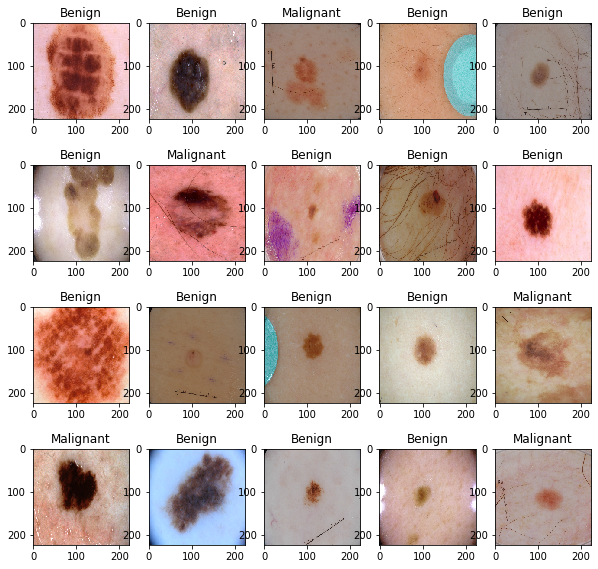

In [ ]:
import matplotlib.pyplot as plt

# Display first 20 images of moles

fig=plt.figure(figsize=(10, 10))

for i in range(1, 20 +1):
    ax = fig.add_subplot(4, 5, i)
    if Y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()


#Label data one hot encoding


In [ ]:
# one hot encoding 
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encodin
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)
Y_val = to_categorical(Y_val, num_classes= 2)

#Normalise Image data np array

In [ ]:
# normalization 
X_train = X_train/255.
X_test = X_test/255.
x_val = X_val/255.

#Image data augmentation. Remove pieces of images randomly


In [ ]:
# method that takes random images and removes random sized rectangle from it
import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

#Image data augmentation pipeline

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.5, # Randomly zoom image 
        width_shift_range=0.5,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.5,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        preprocessing_function=get_random_eraser(p=0.5, v_h=0, s_h=0.25))

#CNN architecture

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import layers
from keras.layers.normalization import BatchNormalization
from keras import regularizers 
import keras
#Define CNN architecture
model = keras.Sequential(
    [
        layers.Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=input_shape, data_format='channels_last'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.Dropout(0.5),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dense(64,activation='softmax'),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(2,activation='softmax')
    ]
)
layers

alpha = 1e-3  # weight decay coefficient

#add weight decay to convolution and any layer that has bias regulizer (Dense Layers)
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 110, 110, 128)     147584    
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 108, 108, 128)     147584    
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 106, 106, 512)     590336    
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 104, 104, 512)     2359808   
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 102, 102, 512)   

#CNN bult using imagenet predefined weights and efficient net B0



In [ ]:
# building the model using weights from imagenet

!pip install -U efficientnet
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
from keras import layers
import efficientnet.keras as efn
from keras import regularizers 

eff_net = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model=Sequential()
model.add(eff_net)
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

alpha = 1e-3  # weight decay coefficient
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda:keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda:keras.regularizers.l2(alpha)(layer.bias))

model.summary()

#Model Visualistaions

In [ ]:
# vizualizing the model 
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#Define Callback funtions 

In [ ]:
#Define call back funtions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
#reduces learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.000005)
#stops the model fitting if the val_loss is not decreasing in 5 epochs
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience = 5)

#Train the model

In [ ]:
#Define optimiser for the model and compile the CNN module
from keras import optimizers
optimizer=optimizers.Adam(lr=learning_rate)
#compile the model
model.compile(optimizer=optimizer,loss="bninary_crossentropy", metrics=['accuracy'])
#train the model
h = model.fit(
    datagen.flow(X_train,Y_train, batch_size=32),
    epochs=30, 
    validation_data=(X_val, Y_val),
    callbacks=[reduce_lr, early_stop])

Epoch 1/30


#Plot accuracy and Loss

Text(0.5, 1.0, 'Loss & Validation Loss')

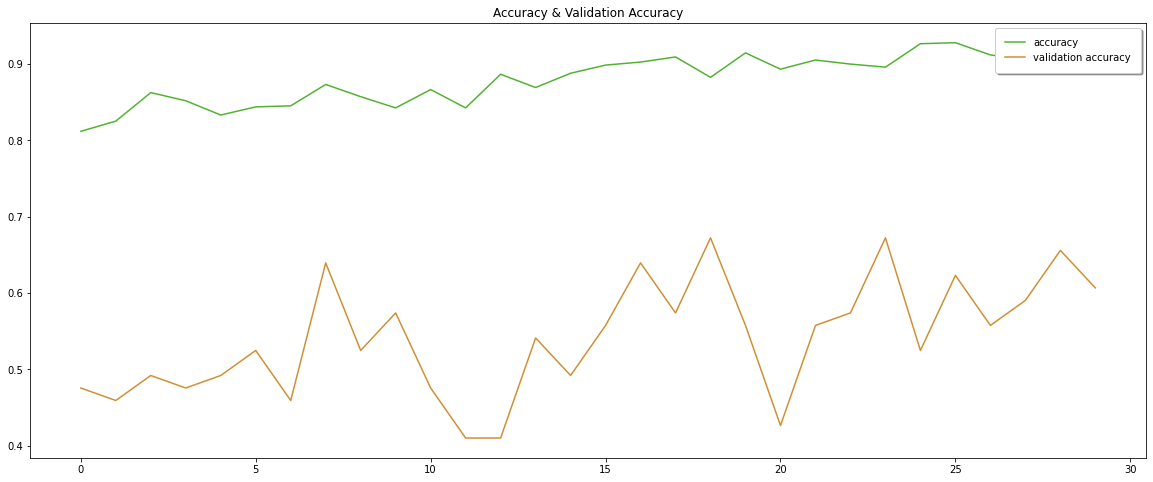

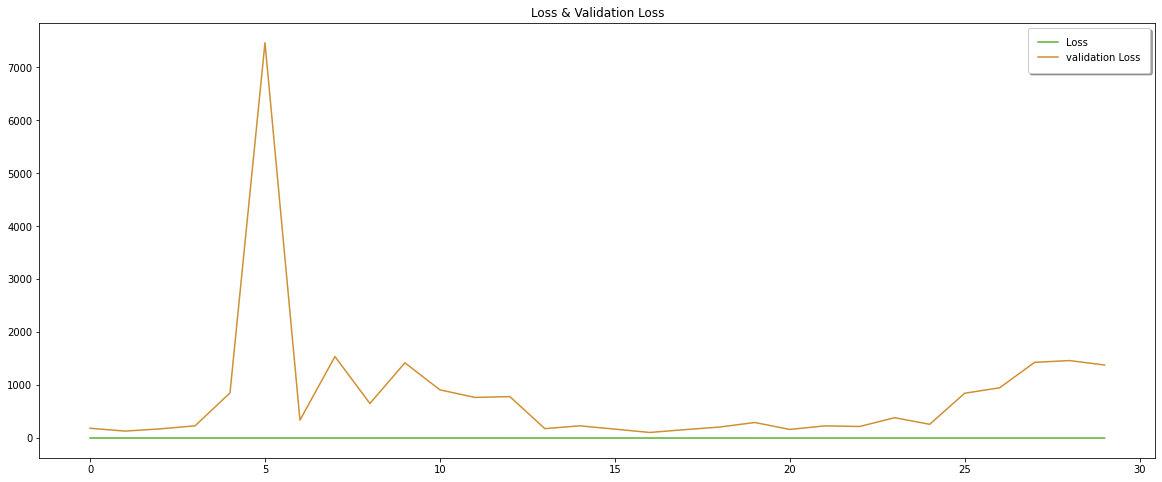

In [ ]:
# accuracy and validation accuracy
plt.figure(figsize=(20,8))
plt.plot(h.history['accuracy'],color="#51B232", label='accuracy')
plt.plot(h.history['val_accuracy'], color="#CF8F32", label='validation accuracy')
plt.legend(loc="upper right",fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.title(label="Accuracy & Validation Accuracy")

#Loss and validation Loss
plt.figure(figsize=(20,8))
plt.plot(h.history['loss'],color="#51B232", label='Loss')
plt.plot(h.history['val_loss'], color="#CF8F32", label='validation Loss')
plt.legend(loc="upper right",fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.title(label="Loss & Validation Loss")

#Evaluate and Run predictions

In [ ]:
# test the model 
results = model.evaluate(X_test, Y_test, batch_size=64)
print('test loss',results[0], 'test acc:',results[1])
results

4/4 [==============================] - 0s 101ms/step - loss: 1.3429 - accuracy: 0.5532
test loss 1.3429222106933594 test acc: 0.5531914830207825


[1.3429222106933594, 0.5531914830207825]

In [ ]:
# test the model
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test, batch_size=64)
print(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

0.5531914893617021


#Calculate confusion matrix and plot it

In [ ]:
#Confution Matrix

pred_results = np.where(y_pred>=0.5, 1,y_pred) 
pred_results2 = np.where(pred_results<0.5, 0,pred_results)

import sklearn
from sklearn.metrics import confusion_matrix
cm= sklearn.metrics.confusion_matrix(Y_test.argmax(axis=1), pred_results2.argmax(axis=1))
print(cm)

[[31 87]
 [18 99]]


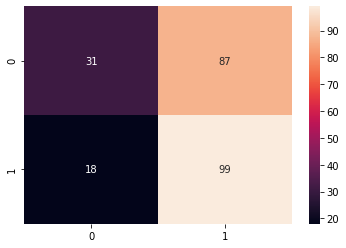

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(cm, annot=True)
plt.show()

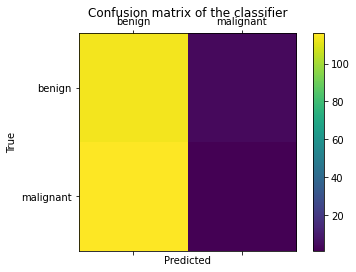

In [ ]:
labels = ['benign', 'malignant']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()